In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex

In this notebook we first preform a basic exploratory analysis of the data contained in the metadata associated to the papers.
Then we look at changes in participation accross the years,

In [2]:
metadata = pd.read_csv('data/Parsed_metadata.csv', index_col=0, parse_dates=['accessioned', 'available', 'issued'])

In [3]:
metadata.shape

(3264, 16)

In [4]:
metadata.head(2)

,file,subject,iso,uri,type,publisher,title,issued,accessioned,citation,available,abstract,long_name,author_order,shortend_names,identifier
0,import2016full_61,NaN,en,info:doi/10.22318/icls2016.61,Book chapter,Singapore: International Society of the Learni...,Exposing Piaget’s Scheme: Empirical Evidence f...,2016-07-01,2017-03-21 12:05:42,"Abrahamson, D., Shayan, S., Bakker, A., & van ...",2017-03-21 12:05:42,The combination of two methodological resource...,"Abrahamson, Dor",0,Abrahamson D.,"Abrahamson, D., Shayan, S., Bakker, A., & van ..."
1,import2016full_95,NaN,en,info:doi/10.22318/icls2016.95,Book chapter,Singapore: International Society of the Learni...,Secondary Teachers’ Emergent Understanding of ...,2016-07-01,2017-03-21 12:05:42,"Sandoval, W. A., Kawasaki, J., Cournoyer, N., ...",2017-03-21 12:05:42,Abstract: The Next Generation Science Standard...,"Sandoval, William A.",0,Sandoval W. A.,"Sandoval, W. A., Kawasaki, J., Cournoyer, N., ..."


The following gives a good overview of the type of values we have in the dataset. The first column gives us the number of values. We can discover NaN values present in the dataset. We see that we ave Nan values in the subject and the abstract column.
We can also see the number of unique values in the second column. We see that long name and shortend name have different amounts of unique values. This means we should use the long name instead. 

In [5]:
#metadata[metadata.abstract.isna()].file.to_csv('NO_abstract_files.csv')
metadata[metadata.abstract.isna()].file.head()

61     import2016full_39
418       import2018_401
431       import2018_463
459       import2018_453
475       import2018_517
Name: file, dtype: object

In [6]:
metadata.count()

file              3264
subject           2387
iso               3264
uri               3264
type              3264
publisher         3264
title             3264
issued            3264
accessioned       3264
citation          3264
available         3264
abstract          3216
long_name         3264
author_order      3264
shortend_names    3264
identifier        3231
dtype: int64

Number of unique authors

In [7]:
len(metadata.long_name.unique())

1971

**Looking more into the naming issue**


We construct an index corresponding to each unique name, for both long and short form. Then, we merge long and short. Where both don't overlap, there is some issue with the naming.

Inspeciting the dataframe one finds that there are two cases: 
- small changes in the string make two identical names non identical.
- the citation order is out of order, and this the short form (based on the citation) was assigned incorrectly.
- the short form name is not unique

In [8]:
unique_long = metadata.long_name.drop_duplicates()
unique_short = metadata.shortend_names.drop_duplicates()
names = metadata[['long_name', 'shortend_names']].drop_duplicates()

index_long = unique_long.reset_index()
index_short = unique_short.reset_index()
names = pd.merge(index_long,names, on='long_name')

differences = pd.merge(index_short, names, on='shortend_names')
differences[differences.index_x != differences.index_y].sample()

,index_x,shortend_names,index_y,long_name
1772,1509,McLaren B. M.,2915,"Campen, Carolien Knoop-van"


In [9]:
differences[differences.shortend_names == 'Flood V. J.']

,index_x,shortend_names,index_y,long_name
30,21,Flood V. J.,21,"Flood, Virginia J."
31,21,Flood V. J.,499,"Flood, Virginia J"


We can fix the first problem by transforming the long form of the string. Now only issue 2 and 3 remain:

In [10]:
import unicodedata

In [11]:
unique_long = metadata.long_name.map(lambda x: regex.sub('\.', '',x)).drop_duplicates()
unique_long = unique_long.map(lambda x: unicodedata.normalize('NFKD', x).encode('ascii','ignore').decode('ascii'))

unique_short = metadata.shortend_names.drop_duplicates()
names = metadata[['long_name', 'shortend_names']].drop_duplicates()

index_long = unique_long.reset_index()
index_short = unique_short.reset_index()
names = pd.merge(index_long,names, on='long_name')

differences = pd.merge(index_short, names, on='shortend_names')
differences[differences.index_x != differences.index_y].sample(5)

,index_x,shortend_names,index_y,long_name
1730,2259,Maggiore C.,2568,"Millet, Chris"
2161,3082,Martin C.,2833,"Pinkard, Nichole"
732,701,Tolar E.,1357,"Silver, Cindy Hmelo"
2215,3199,Clark,1061,"Sagy, Ornit"
1342,1347,Gargroetzi E.,1983,"Chavez, Rosa"


In [12]:
differences[differences.shortend_names =='Tan E.'], differences[differences.shortend_names =='Roy D.']

(    index_x shortend_names  index_y        long_name
 71       55         Tan E.       55      Tan, Esther
 72       55         Tan E.       63        Tan, Edna
 73       55         Tan E.     1691  Shin, Myunghwan, Empty DataFrame
 Columns: [index_x, shortend_names, index_y, long_name]
 Index: [])

Use the cleaned long name string:

In [13]:
metadata.loc['long_name'] = metadata.long_name.map(lambda x: regex.sub('\.', '',x)).map(lambda x: unicodedata.normalize('NFKD', x).encode('ascii','ignore').decode('ascii'))

# Looking at the authors:

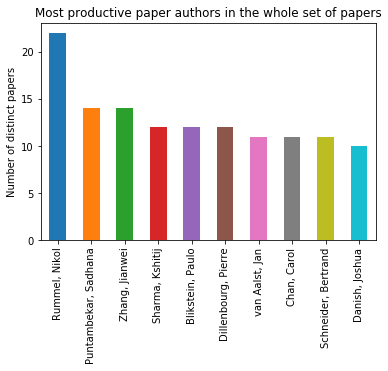

In [14]:
plt.title('Most productive paper authors in the whole set of papers')
plt.ylabel('Number of distinct papers')
metadata.long_name.value_counts().head(10).plot(kind = 'bar')
plt.show()

# Looking at the number of papers: 

We see that more papers get published in ICLS than in CLCS.

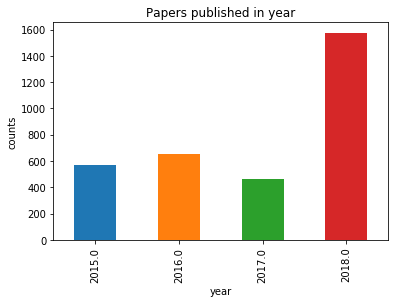

In [15]:
metadata['issued'] = metadata.issued.map(lambda x: x.year)
plt.title('Papers published in year')
plt.xlabel('year')
plt.ylabel('counts')
metadata.issued.value_counts().sort_index().plot(kind='bar')
plt.show()

Here we look at the number of authors in each year:

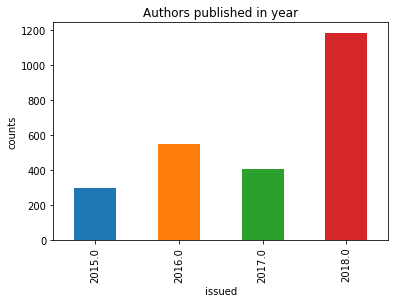

In [16]:
plt.title('Authors published in year')
plt.xlabel('year')
plt.ylabel('counts')
metadata.groupby(['issued']).long_name.unique().map(lambda x: len(x)).plot(kind = 'bar')

In [17]:
#metadata.groupby('issued').shortend_names.value_counts().plot(kind = 'bar')

In each year, every author published the following average papers:

In [18]:
metadata.groupby('issued').long_name.value_counts().groupby('issued').mean()

issued
2015.0    1.935374
2016.0    1.193431
2017.0    1.142157
2018.0    1.331361
Name: long_name, dtype: float64

The median gives quite interessting insight:

In [19]:
metadata.groupby('issued').long_name.value_counts().groupby('issued').median()

issued
2015.0    2
2016.0    1
2017.0    1
2018.0    1
Name: long_name, dtype: int64

The median and average number of authors per paper is:

In [20]:
print("Median number authors per paper {}, Average number of authors per paper {:.4}".format(metadata.file.value_counts().median(), metadata.file.value_counts().mean()))

Median number authors per paper 3.0, Average number of authors per paper 3.735


In [21]:
metadata.groupby('issued').file.value_counts().groupby('issued').median()

issued
2015.0    3
2016.0    3
2017.0    3
2018.0    3
Name: file, dtype: int64

In [22]:
metadata.groupby('issued').file.value_counts().groupby('issued').describe()

,count,mean,std,min,25%,50%,75%,max
issued,,,,,,,,
2015.0,142.0,4.007042,2.812072,1.0,2.0,3.0,5.0,18.0
2016.0,171.0,3.824561,2.799934,1.0,2.0,3.0,4.5,20.0
2017.0,115.0,4.052174,3.521472,1.0,2.0,3.0,4.0,24.0
2018.0,446.0,3.531390,3.007504,1.0,2.0,3.0,4.0,27.0


In [23]:
metadata.groupby('issued').file.value_counts().groupby('issued').std()

issued
2015.0    2.812072
2016.0    2.799934
2017.0    3.521472
2018.0    3.007504
Name: file, dtype: float64

In [24]:
metadata.groupby('issued').file.value_counts().groupby('issued').mean()

issued
2015.0    4.007042
2016.0    3.824561
2017.0    4.052174
2018.0    3.531390
Name: file, dtype: float64

In [25]:
import scipy.stats as stats

Check if the observed difference in average number of authors is significant:
it is not - however, our data might change with more years to observe!
(the difference between only one year of CLCS and ICLS has even higher p value)

In [26]:
stats.ttest_ind(metadata[metadata.issued%2 == 0].file.value_counts() ,metadata[metadata.issued%2 != 0].file.value_counts())

Ttest_indResult(statistic=-1.855662028302758, pvalue=0.06383898143801489)

People who submitted every year of the year:

In [27]:
#get universities by year
uni_year = metadata.groupby('issued').apply(lambda x: set(x['long_name']))

#get years in our dataset
years = uni_year.index.tolist()

#create a set of universities that have participated at some point
unis = uni_year.tolist()
all_ = set()
[all_.update(x) for x in unis]

#now use odd and even years to determine universities that participated every year in either ICLS or CSCL

regulars = unis[0]
ICLS = all_
CSCL = all_
for i, x in enumerate(unis):
    regulars = regulars.intersection(x)
    
    if years[i] % 2 == 0:
        ICLS = ICLS.intersection(x)
    else:
        CSCL = CSCL.intersection(x)
ICLS, CSCL = ICLS.difference(CSCL), CSCL.difference(ICLS)

In [28]:
print('Number of people who submit every year: ', len(regulars))
regulars

Number of people who submit every year:  25


{'Acosta, Alisa',
 'Anderson, Emma',
 'Andrade, Alejandro',
 'Borge, Marcela',
 'Chen, Bodong',
 'Dillenbourg, Pierre',
 'Gnesdilow, Dana',
 'Hartmann, Christian',
 'Kollar, Ingo',
 'Ma, Leanne',
 'Matuk, Camillia',
 'Moher, Tom',
 'Nistor, Nicolae',
 'Oshima, Jun',
 'Oshima, Ritsuko',
 'Puntambekar, Sadhana',
 'Rummel, Nikol',
 'Scardamalia, Marlene',
 'Schneider, Bertrand',
 'Shaffer, David Williamson',
 'Sharma, Kshitij',
 'Thompson, Kate',
 'Weinberger, Armin',
 'Zhang, Jianwei',
 'van Aalst, Jan'}

People who only subitted to 2015 and 2017:

In [29]:
print('Number of CSCL only participants: ', len(CSCL))
#CSCL

Number of CSCL only participants:  46


In [30]:
print('Number of ICLS only participants: ', len(ICLS))
#ICLS_only #uncomment to see al 129 participants

Number of ICLS only participants:  129


## Analyzing the regulars

The metadata associated with the regulars:

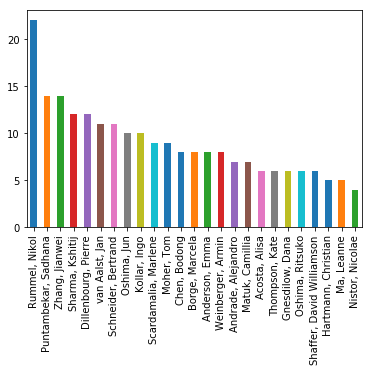

In [31]:
metadata[metadata.long_name.isin(regulars)].long_name.value_counts().plot(kind = 'bar')

Look at how number of pub. per year evolve ... there is not much to see:

In [32]:
regulars = pd.DataFrame(metadata[metadata.long_name.isin(regulars)].groupby('issued').long_name.value_counts())
regulars.columns = ['counts']
regulars.reset_index(inplace=True)

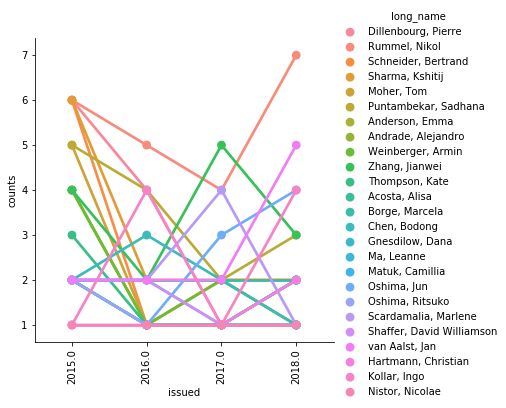

In [33]:
sns.catplot(data=regulars, x='issued', y='counts',kind='point', hue='long_name')
plt.xticks(rotation=90)
plt.show()